# **Medical Image Segmentation Using DC-UNet**

### **Import libraries & datasets**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import os
from PIL import Image
import albumentations as A
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D ,concatenate, BatchNormalization, Activation, Add,add,LeakyReLU
from tensorflow.keras.models import load_model
from PIL import Image
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import jaccard_score
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
# Config
class Config:
    img_size=(256,256)
    batch_size=4
    epochs=10
    learning_rate=1e-4

config=Config()

In [ ]:
# Read and sorting data
name_data_image_path_kvasirseg="../data/Kvasir-SEG/images"
name_data_mask_path_kvasirseg="../data/Kvasir-SEG/masks"
name_data_image_path_clinicdb="../data/CVC-ClinicDB/images"
name_data_mask_path_clinicdb="../data/CVC-ClinicDB/masks"
name_data_image_path_colondb="../data/CVC-ColonDB/images"
name_data_mask_path_colondb="../data/CVC-ColonDB/masks"

data_image_kvasirseg=sorted(os.listdir(name_data_image_path_kvasirseg))
data_mask_kvasirseg=sorted(os.listdir(name_data_mask_path_kvasirseg))
data_image_clinicdb=sorted(os.listdir(name_data_image_path_clinicdb))
data_mask_clinicdb=sorted(os.listdir(name_data_mask_path_clinicdb))
data_image_colondb=sorted(os.listdir(name_data_image_path_colondb))
data_mask_colondb=sorted(os.listdir(name_data_mask_path_colondb))

In [5]:
print("Image path kvasir-seg data: ",data_image_kvasirseg[:3],data_mask_kvasirseg[:3])
print("Image path clinicdb data: ",data_image_clinicdb[:3],data_mask_clinicdb[:3])
print("Image path colondb data: ",data_image_colondb[:3],data_mask_colondb[:3])

Image path kvasir-seg data:  ['cju0qkwl35piu0993l0dewei2.jpg', 'cju0qoxqj9q6s0835b43399p4.jpg', 'cju0qx73cjw570799j4n5cjze.jpg'] ['cju0qkwl35piu0993l0dewei2.jpg', 'cju0qoxqj9q6s0835b43399p4.jpg', 'cju0qx73cjw570799j4n5cjze.jpg']
Image path clinicdb data:  ['1.png', '10.png', '100.png'] ['1.png', '10.png', '100.png']
Image path colondb data:  ['1.png', '10.png', '100.png'] ['1.png', '10.png', '100.png']


In [6]:
# Concat data
data_images_combined = (
    [os.path.join(name_data_image_path_kvasirseg, img) for img in data_image_kvasirseg] +
    [os.path.join(name_data_image_path_clinicdb, img) for img in data_image_clinicdb] +
    [os.path.join(name_data_image_path_colondb, img) for img in data_image_colondb]
)

data_masks_combined = (
    [os.path.join(name_data_mask_path_kvasirseg, mask) for mask in data_mask_kvasirseg] +
    [os.path.join(name_data_mask_path_clinicdb, mask) for mask in data_mask_clinicdb] +
    [os.path.join(name_data_mask_path_colondb, mask) for mask in data_mask_colondb]
)
len(data_images_combined),len(data_masks_combined)

(1992, 1992)

### **Process and prepare data**

In [7]:
def split_data_train_valid_test(images_data,masks_data):
    paired_list_data=list(zip(images_data,masks_data))
    np.random.shuffle(paired_list_data)
    data_img,data_mask=zip(*paired_list_data)

    train_images_list,val_images_list,train_masks_list,val_masks_list = train_test_split(data_img,data_mask,test_size=0.1,random_state=42)

    return (
        train_images_list,train_masks_list,
        val_images_list,val_masks_list,
        #test_images_list,test_masks_list,
    )


In [8]:
# Data splitting
train_images_list,train_masks_list,val_images_list,val_masks_list=split_data_train_valid_test(data_images_combined,data_masks_combined)
len(train_images_list),len(train_masks_list),len(val_images_list),len(val_masks_list)

(1792, 1792, 200, 200)

In [9]:
# Transform
train_transform = A.Compose([
    A.Resize(*config.img_size),
    A.Rotate(limit=15, p=0.2), 
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),  
    A.Normalize(mean=(0,0,0), std=(1,1,1), max_pixel_value=255)
])

val_transform=A.Compose([
    A.Resize(*config.img_size),
    A.Normalize(mean=(0,0,0),std=(1,1,1),max_pixel_value=255)
])

In [10]:
# Initalizedd class Dataset
class Dataset(keras.utils.Sequence):
    def __init__(self, img_list, mask_list, transform, batch_size=4):
        self.img_list = img_list  # Full path
        self.mask_list = mask_list
        self.transform = transform
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.img_list) / self.batch_size))
        
    def __getitem__(self, index):
        batch_img_paths = self.img_list[index * self.batch_size : (index + 1) * self.batch_size]
        batch_mask_paths = self.mask_list[index * self.batch_size : (index + 1) * self.batch_size]

        images, masks = [], []
        for img_path, mask_path in zip(batch_img_paths, batch_mask_paths):
            img = Image.open(img_path).convert("RGB")  
            mask = Image.open(mask_path).convert("L")

            mask = np.array(mask) / 255.0
            mask[mask > 0.5] = 1

            augmented = self.transform(image=np.array(img), mask=mask)
            images.append(augmented["image"])
            masks.append(np.expand_dims(augmented["mask"], axis=-1))

        return np.array(images), np.array(masks)


In [11]:
train_dataset = Dataset(train_images_list, train_masks_list, train_transform)
valid_dataset = Dataset(val_images_list, val_masks_list, train_transform)

#### **Initialize Dual channel Unet model**

In [12]:
def conv2d_bn(x, filters, kernel_size, padding='same', strides=(1, 1), activation='relu'):
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)
    if activation:
        if activation == 'leaky_relu':
            x = LeakyReLU(alpha=0.01)(x)  
        else:
            x = Activation(activation)(x) 
    return x

def DCBlock(U, inp, alpha=1.67):
    W = alpha * U

    conv3x3_1 = conv2d_bn(inp, int(W * 0.167), (3, 3))
    conv5x5_1 = conv2d_bn(conv3x3_1, int(W * 0.333), (3, 3))
    conv7x7_1 = conv2d_bn(conv5x5_1, int(W * 0.5), (3, 3))
    out1 = concatenate([conv3x3_1, conv5x5_1, conv7x7_1])

    conv3x3_2 = conv2d_bn(inp, int(W * 0.167), (3, 3))
    conv5x5_2 = conv2d_bn(conv3x3_2, int(W * 0.333), (3, 3))
    conv7x7_2 = conv2d_bn(conv5x5_2, int(W * 0.5), (3, 3))
    out2 = concatenate([conv3x3_2, conv5x5_2, conv7x7_2])

    out = Add()([out1, out2])
    out = Activation('relu')(out)
    out = BatchNormalization()(out)

    return out

def ResPath(filters, length, inp):
    shortcut = conv2d_bn(inp, filters, (1, 1), activation=None)
    out = conv2d_bn(inp, filters, (3, 3))
    out = Add()([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3, scale=False)(out)

    for _ in range(length - 1):
        shortcut = conv2d_bn(out, filters, (1, 1), activation=None)
        out = conv2d_bn(out, filters, (3, 3))
        out = Add()([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3, scale=False)(out)

    return out

def DCUNet(height, width, channels):
    inputs = Input((height, width, channels))
    # Downsampling path
    dcblock1 = DCBlock(32, inputs)
    pool1 = MaxPooling2D((2, 2))(dcblock1)
    dcblock1 = ResPath(32, 4, dcblock1)

    dcblock2 = DCBlock(64, pool1)
    pool2 = MaxPooling2D((2, 2))(dcblock2)
    dcblock2 = ResPath(64, 3, dcblock2)

    dcblock3 = DCBlock(128, pool2)
    pool3 = MaxPooling2D((2, 2))(dcblock3)
    dcblock3 = ResPath(128, 2, dcblock3)

    dcblock4 = DCBlock(256, pool3)
    pool4 = MaxPooling2D((2, 2))(dcblock4)
    dcblock4 = ResPath(256, 1, dcblock4)

    dcblock5 = DCBlock(512, pool4)

    # Upsampling path
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(dcblock5), dcblock4])
    dcblock6 = DCBlock(256, up6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(dcblock6), dcblock3])
    dcblock7 = DCBlock(128, up7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(dcblock7), dcblock2])
    dcblock8 = DCBlock(64, up8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(dcblock8), dcblock1])
    dcblock9 = DCBlock(32, up9)

    outputs = conv2d_bn(dcblock9, 1, (1, 1), activation='sigmoid')

    return Model(inputs, outputs, name="DC-UNet")

dc_model = DCUNet(256, 256, 3)
dc_model.summary()

Model: "DC-UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 8)    │            216 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 8)    │            216 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 8)    │             24 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 256, 256, 8)    │             24 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 8)    │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 256, 256, 8)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 17)   │          1,224 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 256, 256, 17)   │          1,224 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 17)   │             51 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 256, 256, 17)   │             51 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 17)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activation) │ (None, 256, 256, 17)   │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 26)   │          3,978 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 256, 256, 26)   │          3,978 │ activation_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256, 256, 26)   │             78 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 256, 256, 26)   │             78 │ conv2d_5[0][0]         │
│ (BatchNormalization) 

 Total params: 10,049,568 (38.34 MB)

 Trainable params: 10,029,928 (38.26 MB)

 Non-trainable params: 19,640 (76.72 KB)

### **Training model**

In [13]:
dc_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=config.learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),  
    metrics=[tf.keras.metrics.BinaryCrossentropy(from_logits=False)]  
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_dc-unet_model.keras",  
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1,
    save_weights_only=False 
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    patience=10, 
    restore_best_weights=True
)

history = dc_model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=150,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/150
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - binary_crossentropy: 0.6893 - loss: 0.6893
Epoch 1: val_loss improved from inf to 0.85369, saving model to best_dc-unet_model.keras
448/448 ━━━━━━━━━━━━━━━━━━━━ 144s 149ms/step - binary_crossentropy: 0.6893 - loss: 0.6893 - val_binary_crossentropy: 0.8537 - val_loss: 0.8537
Epoch 2/150
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - binary_crossentropy: 0.6164 - loss: 0.6164
Epoch 2: val_loss improved from 0.85369 to 0.70286, saving model to best_dc-unet_model.keras
448/448 ━━━━━━━━━━━━━━━━━━━━ 59s 131ms/step - binary_crossentropy: 0.6164 - loss: 0.6164 - val_binary_crossentropy: 0.7029 - val_loss: 0.7029
Epoch 3/150
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - binary_crossentropy: 0.5740 - loss: 0.5740
Epoch 3: val_loss improved from 0.70286 to 0.55892, saving model to best_dc-unet_model.keras
448/448 ━━━━━━━━━━━━━━━━━━━━ 59s 131ms/step - binary_crossentropy: 0.5739 - loss: 0.5739 - val_binary_crossentropy: 0.5589 - val_loss: 0.558

In [14]:
best_model = tf.keras.models.load_model("best_dc-unet_model.keras") # Load .keras and convert to .h5
best_model.save("best_dc-unet_model.h5", save_format="h5")
print("Best model save successfully!")

dc_model.save("dc-unet_model.h5")
print("Model final save successfully!")

Best model save successfully!
Model final save successfully!


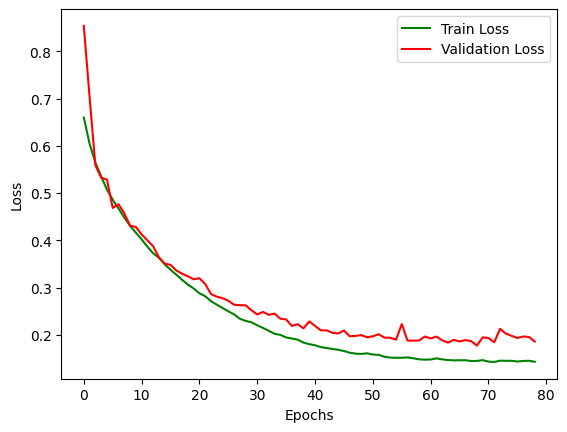

In [15]:
# Visualize
plt.plot(history.history["loss"], label="Train Loss", color="green")
plt.plot(history.history["val_loss"], label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()